In [1]:
!pip install torchsummary

In [2]:

import os                       # for working with files
import numpy as np              # for numerical computationss
import pandas as pd             # for working with dataframes
import torch                    # Pytorch module
import matplotlib.pyplot as plt # for plotting informations on graph and images using tensors
import torch.nn as nn           # for creating  neural networks
from torch.utils.data import DataLoader # for dataloaders
from PIL import Image           # for checking images
import torch.nn.functional as F # for functions for calculating loss
import torchvision.transforms as transforms   # for transforming images into tensors
from torchvision.utils import make_grid       # for data checking
from torchvision.datasets import ImageFolder  # for working with classes and images
from torchsummary import summary              # for getting the summary of our model

In [3]:
data_dir = "../input/new-plant-diseases-dataset/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)"
train_dir = data_dir + "/train"
valid_dir = data_dir + "/valid"
diseases = os.listdir(train_dir)

In [4]:
plants = []
NumberOfDiseases = 0
for plant in diseases:
    if plant.split('___')[0] not in plants:
        plants.append(plant.split('___')[0])
    if plant.split('___')[1] != 'healthy':
        NumberOfDiseases += 1

In [5]:
# number of unique plants
print("Number of plants: {}".format(len(plants)))
# number of unique diseases
print("Number of diseases: {}".format(NumberOfDiseases))

Number of plants: 14
Number of diseases: 26


In [6]:
# Number of images for each disease
nums = {}
for disease in diseases:
    nums[disease] = len(os.listdir(train_dir + '/' + disease))

# converting the nums dictionary to pandas dataframe passing index as plant name and number of images as column

img_per_class = pd.DataFrame(nums.values(), index=nums.keys(), columns=["no. of images"])
img_per_class

,no. of images
Tomato___Late_blight,1851
Tomato___healthy,1926
Grape___healthy,1692
Orange___Haunglongbing_(Citrus_greening),2010
Soybean___healthy,2022
Squash___Powdery_mildew,1736
Potato___healthy,1824
Corn_(maize)___Northern_Leaf_Blight,1908
Tomato___Early_blight,1920
Tomato___Septoria_leaf_spot,1745


In [7]:
n_train = 0
for value in nums.values():
    n_train += value
print(f"There are {n_train} images for training")

There are 70295 images for training


In [8]:
n_valid = 0
for value in nums.values():
    n_valid += value
print(f"There are {n_valid} images for validation")

There are 70295 images for validation


In [9]:
# datasets for validation and training
train = ImageFolder(train_dir, transform=transforms.ToTensor())
valid = ImageFolder(valid_dir, transform=transforms.ToTensor())

In [10]:
img, label = train[0]
print(img.shape, label)

torch.Size([3, 256, 256]) 0


In [11]:
# Setting the seed value
random_seed = 7
torch.manual_seed(random_seed)

In [12]:
# setting the batch size
batch_size = 32

In [13]:
# DataLoaders for training and validation
train_dl = DataLoader(train, batch_size, shuffle=True, num_workers=2, pin_memory=True)
valid_dl = DataLoader(valid, batch_size, num_workers=2, pin_memory=True)

In [14]:
# for moving data into GPU (if available)
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available:
        return torch.device("cuda")
    else:
        return torch.device("cpu")

# for moving data to device (CPU or GPU)
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

# for loading in the device (GPU if available else CPU)
class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [15]:
device = get_default_device()
device

device(type='cuda')

In [16]:

from torch.utils.data import random_split

# Calculate the size of the test set
test_size = int(0.1 * len(train))
train_size = len(train) - test_size

# Split the training data into train and test sets
train_data, test_data = random_split(train, [train_size, test_size])

# Create DataLoaders for the new train and test sets
train_dl = DataLoader(train_data, batch_size, shuffle=True, num_workers=2, pin_memory=True)
test_dl = DataLoader(test_data, batch_size, num_workers=2, pin_memory=True)


In [17]:
# Moving data into GPU
train_dl = DeviceDataLoader(train_dl, device)
valid_dl = DeviceDataLoader(valid_dl, device)
test_dl  = DeviceDataLoader(test_dl, device)

In [18]:

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models

# Define the fine-tune function
def fine_tune_mobilenetv3(num_classes):
    """
    Fine-tunes a MobileNetV3 model for a given number of classes.

    Args:
        num_classes: The number of output classes.

    Returns:
        A fine-tuned MobileNetV3 model.
    """
    # Load the pre-trained MobileNetV3 model
    model = models.mobilenet_v3_small(pretrained=True)

    # Freeze the initial layers
    for param in model.features[:10].parameters():
        param.requires_grad = False

    # Modify the classifier for the new number of classes
    num_ftrs = model.classifier[0].in_features
    model.classifier = nn.Sequential(
        nn.Linear(576, 38),
        nn.Softmax(dim=1)
    )

    return model

In [19]:
model = fine_tune_mobilenetv3(num_classes=len(train.classes))

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Move the model to the device (GPU or CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_dl:
        # Move images and labels to the device
        images, labels = images.to(device), labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        # Accumulate the running loss and accuracy
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    # Print training statistics
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_dl):.4f}, Accuracy: {100 * correct/total:.2f}%')

    # Validation phase
    model.eval()  # Set the model to evaluation mode
    val_loss = 0.0
    val_correct = 0
    val_total = 0

    with torch.no_grad():  # Disable gradient calculation for validation
        for val_images, val_labels in valid_dl:
            val_images, val_labels = val_images.to(device), val_labels.to(device)

            val_outputs = model(val_images)
            val_loss += criterion(val_outputs, val_labels).item()

            _, val_predicted = torch.max(val_outputs.data, 1)
            val_total += val_labels.size(0)
            val_correct += val_predicted.eq(val_labels).sum().item()

    # Print validation statistics
    print(f'Validation Loss: {val_loss/len(valid_dl):.4f}, Validation Accuracy: {100 * val_correct/val_total:.2f}%')

# Save the trained model if needed
torch.save(model.state_dict(), 'mobilenetv3_finetuned.pth')

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V3_Small_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V3_Small_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/mobilenet_v3_small-047dcff4.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v3_small-047dcff4.pth
100%|██████████| 9.83M/9.83M [00:00<00:00, 83.0MB/s]


Epoch [1/10], Loss: 2.7913, Accuracy: 90.48%
Validation Loss: 2.7278, Validation Accuracy: 95.82%
Epoch [2/10], Loss: 2.7160, Accuracy: 96.93%
Validation Loss: 2.7134, Validation Accuracy: 97.09%
Epoch [3/10], Loss: 2.7062, Accuracy: 97.75%
Validation Loss: 2.7043, Validation Accuracy: 97.89%
Epoch [4/10], Loss: 2.7020, Accuracy: 98.18%
Validation Loss: 2.7031, Validation Accuracy: 97.93%
Epoch [5/10], Loss: 2.6989, Accuracy: 98.42%
Validation Loss: 2.6983, Validation Accuracy: 98.37%
Epoch [6/10], Loss: 2.6972, Accuracy: 98.57%
Validation Loss: 2.6957, Validation Accuracy: 98.69%
Epoch [7/10], Loss: 2.6960, Accuracy: 98.69%
Validation Loss: 2.7014, Validation Accuracy: 98.11%
Epoch [8/10], Loss: 2.6944, Accuracy: 98.84%
Validation Loss: 2.6986, Validation Accuracy: 98.34%
Epoch [9/10], Loss: 2.6932, Accuracy: 98.91%
Validation Loss: 2.6923, Validation Accuracy: 98.96%
Epoch [10/10], Loss: 2.6925, Accuracy: 98.98%
Validation Loss: 2.6948, Validation Accuracy: 98.73%


In [20]:

# Evaluation on the test set
model.eval()  # Set the model to evaluation mode
test_loss = 0.0
test_correct = 0
test_total = 0

with torch.no_grad():  # Disable gradient calculation for testing
    for test_images, test_labels in test_dl:
        test_images, test_labels = test_images.to(device), test_labels.to(device)

        test_outputs = model(test_images)
        test_loss += criterion(test_outputs, test_labels).item()

        _, test_predicted = torch.max(test_outputs.data, 1)
        test_total += test_labels.size(0)
        test_correct += test_predicted.eq(test_labels).sum().item()

# Print test statistics
print(f'Test Loss: {test_loss/len(test_dl):.4f}, Test Accuracy: {100 * test_correct/test_total:.2f}%')


Test Loss: 2.6910, Test Accuracy: 99.12%


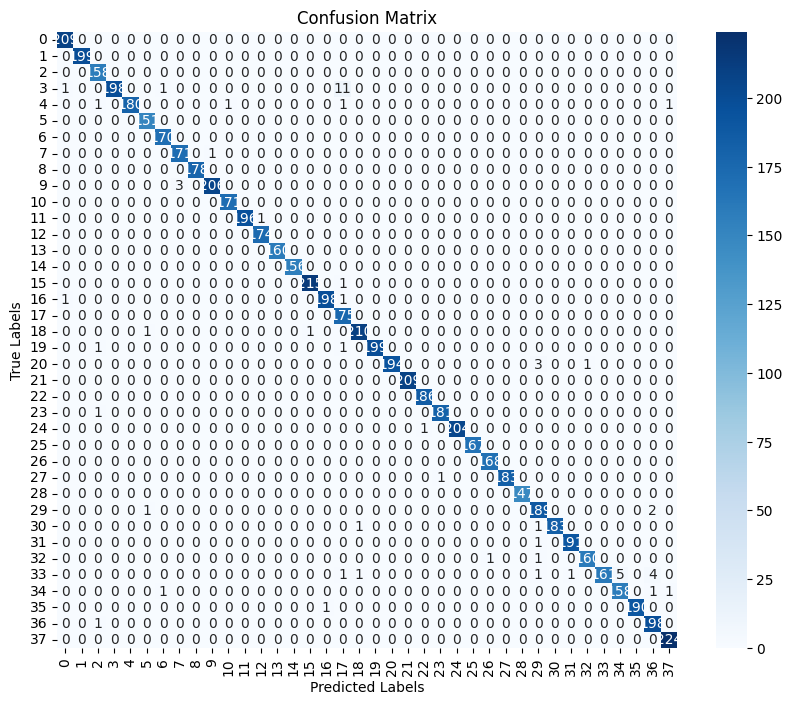

In [21]:

import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Get predictions on the test set
y_pred = []
y_true = []
with torch.no_grad():
  for images, labels in test_dl:
      images, labels = images.to(device), labels.to(device)
      outputs = model(images)
      _, predicted = torch.max(outputs.data, 1)
      y_pred.extend(predicted.cpu().numpy())
      y_true.extend(labels.cpu().numpy())

# Calculate the confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()


In [24]:

from sklearn.metrics import recall_score, precision_score, f1_score, accuracy_score

# Calculate recall
recall = recall_score(y_true, y_pred, average='weighted')
print(f"Recall: {recall:.4f}")

# Calculate precision
precision = precision_score(y_true, y_pred, average='weighted')
print(f"Precision: {precision:.4f}")

# Calculate F1-score
f1 = f1_score(y_true, y_pred, average='weighted')
print(f"F1-score: {f1:.4f}")

# Calculate accuracy
accuracy = accuracy_score(y_true, y_pred)
print(f"Accuracy: {accuracy:.4f}")


Recall: 0.9912
Precision: 0.9915
F1-score: 0.9912
Accuracy: 0.9912


In [25]:
# saving to the kaggle working directory
PATH = './plant-disease-model_final.pth'
torch.save(model.state_dict(), PATH)

In [26]:
# saving the entire model to working directory
PATH = './plant-disease-model-complete_final.pth'
torch.save(model, PATH)